## Objective
Earlier notebook titanic.ipynb was only using LogisticRegression  
Here Grid search would be used to get the optimum model using hyperparameters variations

In [54]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.metrics import roc_curve, auc


In [55]:
def replace_nan_frequent_val(df, column_name):
    """
    Replace NaN values with the most frequent value in the specified column.

    Parameters:
    - df: pandas DataFrame
    - column_name: str, the name of the column to process
    """
    # Replace NaN values with the most frequent value in the 'column_name' column
    most_frequent_value = df[column_name].mode()[0]
    df[column_name] = df[column_name].fillna(most_frequent_value)


In [56]:

def replace_nan_with_existing_val(df, column):
    """
    Replace NaN values in a DataFrame column with existing non-NaN values randomly.

    Parameters:
    - df: pandas DataFrame
    - column: str, the name of the column to process
    """
    # Get indices of NaN values in the specified column
    nan_indices = df.index[df[column].isna()].tolist()
    
    # Count the number of NaN values
    num_nans = len(nan_indices)
    
    # Check where values are not NaN, creating a replacement list
    value_index = df.index[df[column].notna()].tolist()
    replacement_list = df.loc[value_index, column].values.tolist()
    
    # Generate random values from the replacement list
    random_values = np.random.choice(replacement_list, size=num_nans)
    
    # Replace NaN values with randomly chosen values
    df.loc[nan_indices, column] = random_values


In [57]:
def preprocess_dataframe(numerical_features, categorical_features, df):
    """
    This function preprocesses a DataFrame by replacing NaN values and scaling numerical features.

    Parameters:
    - numerical_features: list, names of numerical columns
    - categorical_features: list, names of categorical columns
    - df: pandas DataFrame, the input DataFrame

    Returns:
    - X_preprocessed: numpy array, preprocessed feature matrix
    - feature_names: list, names of the output features after preprocessing
    """

    # Create transformers for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit and transform the data using the preprocessor
    X_preprocessed = preprocessor.fit_transform(df)

    # Get output feature names
    feature_names = preprocessor.get_feature_names_out()

    return X_preprocessed, feature_names


In [58]:
def extract_target_column(df,target_col):
    """
      function extracts target column from dataframe .
      converts it to integer and returns post flattening.
    """
    tran_y= df.pop(target_col)
    # type would be pandas.core.series.Series
    type(tran_y)
    y = pd.DataFrame(tran_y)
    y[target_col] = y[target_col].astype(int)
    y = y.values
    y = y.ravel()
    return y

In [59]:
def append_index(index, new_index):
    """
    Concatenate a new index with an existing index.

    Parameters:
    - index: pandas Index, the existing index
    - new_index: pandas Index, the index to be appended

    Returns:
    - combined_index: pandas Index, the combined index
    """
    # Concatenate the new index with the existing index
    combined_index = pd.Index(index.tolist() + new_index.tolist())
    
    # Return the combined index
    return combined_index


In [60]:
def dump_list_to_file(my_list, file_path):
    """
    Dump a list to a regular text file.

    Parameters:
    - my_list: list, the list to be dumped
    - file_path: str, the path to the output text file
    """
    # Dump the list to a text file
    with open(file_path, 'w') as file:
        for item in my_list:
            file.write(str(item) + '\n')

In [61]:
def plot_kde(data_column, df, title_name=None):
    """
    Visualize the frequency distribution using a KDE plot.

    Parameters:
    - data_column: str, the column to visualize
    - df: pandas DataFrame, the input DataFrame
    - title_name: str, the title for the plot (default is dynamically generated)

    Returns:
    None
    """
    # If title_name is not provided, generate a default title
    if title_name is None:
        title_name = f'Frequency Distribution of {data_column} KDE plot'

    # Visualize the frequency distribution using a KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=data_column, fill=True, color='skyblue', common_norm=False)
    plt.title(title_name)
    plt.xlabel(data_column)
    plt.ylabel('Density')
    plt.show()

In [62]:
def split_and_adjust(df):
    """
    Process the given DataFrame by splitting columns and converting data types.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame to be processed.

    Returns:
    None

    This function splits the 'PassengerId' and 'Cabin' columns, converts data types,
    and handles missing values to prepare the DataFrame for further analysis.
    """
    # Split the PassengerId into 2 columns: Group and NumInGroup
    df[['Group', 'NumInGroup']] = df["PassengerId"].str.split("_", expand=True)
    
    # Split the Cabin column into 3 columns: CabinDeck, CabinNum, and CabinSide
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df["Cabin"].str.split("/", expand=True)
    
    # Convert the 'Group' column to integer type
    df["Group"] = df["Group"].astype(int)
    
    # Replace NaN values in the "CabinNum" column with existing values
    replace_nan_with_existing_val(df, "CabinNum")
    
    # Convert the 'CabinNum' column to integer type to reduce the number of columns during preprocessing
    df["CabinNum"] = df["CabinNum"].astype(int)
    # check for NAN still exist, value of 0 indicates there is no NAN
    nan_len= len(df.index[df.CabinNum.isna()].tolist())
    assert nan_len == 0

    # drop the original column PassengerId and Cabin .
    # also drop name , does not have significance
    df.drop( ["Cabin", "Name", "PassengerId"], axis = 1 ,inplace=True)


In [63]:
# To suppress all warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv("C:\\Users\\u725561\\machine-learning\\spaceship-titanic\\train.csv")

Check how many unique Homeplanets are present

In [65]:
df.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [66]:
# check count of unique home planets
df.HomePlanet.nunique()

3

In [67]:
# Perform data manipulation
split_and_adjust(df)

In [68]:
# check the distribution of Cabin Deck . Seems F , G are more frequent
df.CabinDeck.value_counts()

CabinDeck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

In [69]:
df.CabinNum.info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: CabinNum
Non-Null Count  Dtype
--------------  -----
8693 non-null   int32
dtypes: int32(1)
memory usage: 34.1 KB


In [70]:
df.CabinNum.value_counts()

CabinNum
82      28
19      24
86      24
176     22
56      21
        ..
651      1
1682     1
1678     1
1282     1
1894     1
Name: count, Length: 1817, dtype: int64

In [71]:
# find total number of NaN values in the column CabinNum
df.CabinNum.isna().sum()

0

In [72]:
# find out indices for NaN values for Cabin Num
cabinNum_nan = df.index[df.CabinNum.isna()].tolist()
len(cabinNum_nan)

0

In [73]:
df.Group.value_counts()

Group
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: count, Length: 6217, dtype: int64

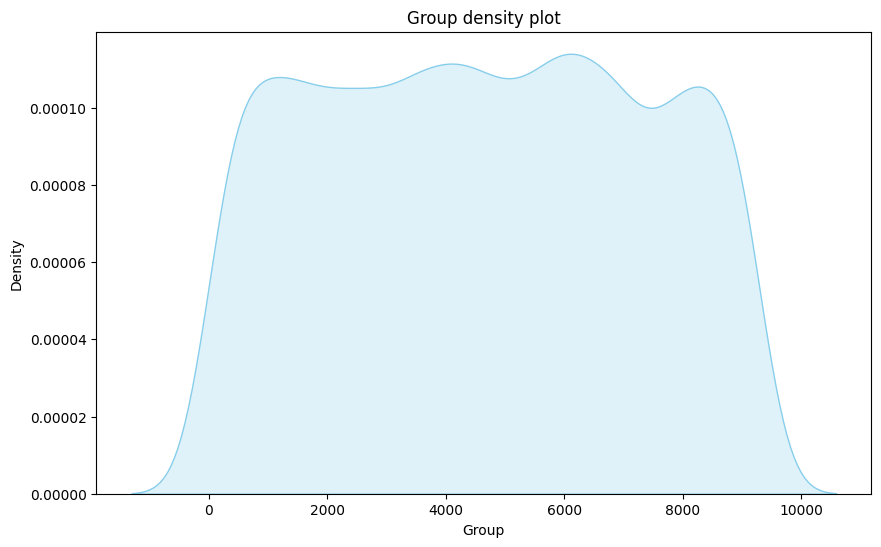

In [74]:
# check the frequency distribution for Group column. looks evenly distributed
plot_kde('Group',df,'Group density plot')

In [75]:
# Observe CabinNum is object , which is string , need to convert to int
df.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Group             int32
NumInGroup       object
CabinDeck        object
CabinNum          int32
CabinSide        object
dtype: object

In [76]:
# observed that CabinNum 82 has frequency unchanged /not changed much
df.CabinNum.value_counts()

CabinNum
82      28
19      24
86      24
176     22
56      21
        ..
651      1
1682     1
1678     1
1282     1
1894     1
Name: count, Length: 1817, dtype: int64

In [77]:
# check the distribution of CabinSide . It has only 2 unique values S and P . Probably should drop ?
df.CabinSide.value_counts()

CabinSide
S    4288
P    4206
Name: count, dtype: int64

In [78]:
# Check whether the target variable is distributed uniformly . would observe that almost evenly distributed
df.Transported.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [79]:
# print entire dataframe with new columns
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,NumInGroup,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276,01,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278,01,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279,01,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,01,E,608,S


In [80]:
# extract target column into a numpy array . This would go into fit as argument 
y = extract_target_column(df,"Transported")
y

array([0, 1, 0, ..., 1, 0, 1])

In [81]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,NumInGroup,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,1,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,2,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,3,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,3,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,4,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,9276,01,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,9278,01,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,9279,01,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,9280,01,E,608,S


In [82]:
df.shape

(8693, 15)

In [83]:
df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [84]:
type(y)

numpy.ndarray

Check columns which has null . 
we will do *preprocessing* on the dataframe .

In [85]:
null_columns = df.columns[df.isna().any()].tolist()
print(null_columns)

['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinDeck', 'CabinSide']


preprocessing data for catrgorical and numerical columns


In [86]:
# Separate features into numerical and categorical
numerical_features = df.select_dtypes(include=['float64','int32']).columns
print(f"numerical features {numerical_features}")
categorical_features = df.select_dtypes(include=['object']).columns
print(f"categorical features {categorical_features}")


numerical features Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group', 'CabinNum'],
      dtype='object')
categorical features Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NumInGroup',
       'CabinDeck', 'CabinSide'],
      dtype='object')


In [87]:
type(numerical_features)

pandas.core.indexes.base.Index

In [88]:
X_preprocessed , feature_names = preprocess_dataframe(numerical_features, categorical_features, df)

In [89]:
# check that preprocessing has increased the number of coluns
X_preprocessed.shape

(8693, 36)

In [90]:
file_path= 'C:\\Users\\u725561\\machine-learning\\kaggle-learning\\feature_names.txt'
dump_list_to_file(feature_names,file_path)

In [91]:
len(feature_names)

36

In [92]:
type(X_preprocessed)

numpy.ndarray

In [93]:
X_preprocessed.shape

(8693, 36)

In [94]:
type(X_preprocessed)

numpy.ndarray

In [95]:
X_preprocessed_df = pd.DataFrame(data=X_preprocessed, columns=feature_names)

# Display the preprocessed DataFrame
print(X_preprocessed_df)

      num__Age  num__RoomService  num__FoodCourt  num__ShoppingMall  num__Spa  \
0     0.709437         -0.340590       -0.287314          -0.290817 -0.276663   
1    -0.336717         -0.175364       -0.281669          -0.248968  0.211505   
2     2.034566         -0.275409        1.955616          -0.290817  5.694289   
3     0.290975         -0.340590        0.517406           0.330225  2.683471   
4    -0.894666          0.118709       -0.243409          -0.038048  0.225732   
...        ...               ...             ...                ...       ...   
8688  0.848924         -0.340590        3.989682          -0.290817  1.184286   
8689 -0.755179         -0.340590       -0.287314          -0.290817 -0.276663   
8690 -0.197230         -0.340590       -0.287314           2.842851 -0.275774   
8691  0.221232         -0.340590        0.370637          -0.290817  0.037223   
8692  1.058155         -0.149594        2.653082          -0.290817 -0.276663   

      num__VRDeck  num__Gro

In [96]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [97]:
# Define the hyperparameters and their possible values for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],  # its small dataset .sag and saga will not be required
    'max_iter': [100, 200, 300],
    'class_weight' : [ 'balanced','dictionary','None']
}

In [98]:
# Create a Logistic Regression model
logreg = LogisticRegression(random_state=42)

In [99]:
# Create the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

In [100]:
# Train the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', 'dictionary', 'None'],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [101]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [102]:
# Get the best model
best_model = grid_search.best_estimator_

In [103]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [104]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [105]:
# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.7809085681426107

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       861
           1       0.77      0.81      0.79       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [106]:
cm = confusion_matrix(y_test,y_pred)

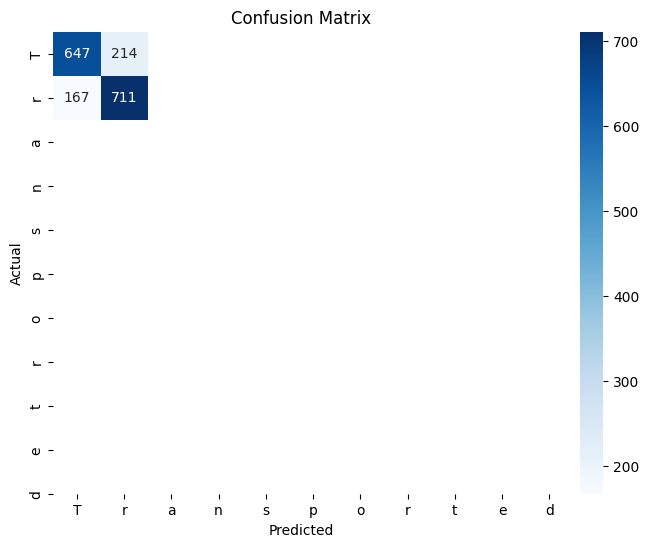

In [107]:
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels='Transported', yticklabels='Transported')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

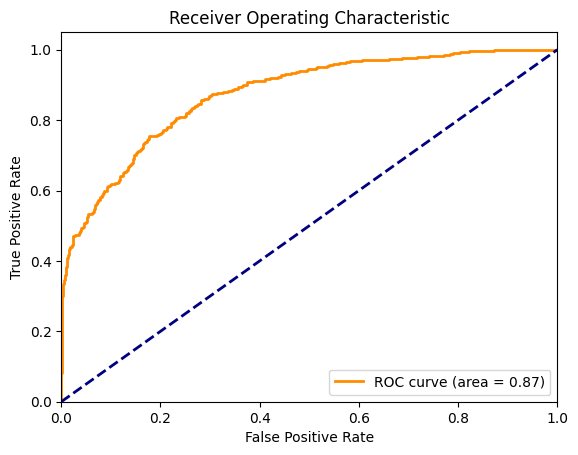

In [110]:
# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [107]:
coefficients = best_model.coef_[0]

# Print feature names and coefficients
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

num__Age: -0.08710788278422801
num__RoomService: -1.048897996378101
num__FoodCourt: 0.8175321622482323
num__ShoppingMall: 0.33291468144413144
num__Spa: -2.299465419002288
num__VRDeck: -2.1752541008747652
num__Group: 0.11707515563417875
num__CabinNum: -0.034464032029844445
cat__HomePlanet_Earth: -0.5765421982038414
cat__HomePlanet_Europa: 0.7873888180030196
cat__HomePlanet_Mars: 0.0
cat__CryoSleep_False: -0.6582635095558718
cat__CryoSleep_True: 0.6806529710592021
cat__Destination_55 Cancri e: 0.44804406372459943
cat__Destination_PSO J318.5-22: 0.0
cat__Destination_TRAPPIST-1e: 0.0
cat__VIP_False: 0.0
cat__VIP_True: -0.12205116524114412
cat__NumInGroup_01: 0.0
cat__NumInGroup_02: 0.1489472015165084
cat__NumInGroup_03: 0.32647542321697626
cat__NumInGroup_04: 0.20989540720028282
cat__NumInGroup_05: -0.1160972614794914
cat__NumInGroup_06: 0.0
cat__NumInGroup_07: -0.2315704190302917
cat__NumInGroup_08: 0.0
cat__CabinDeck_A: -0.5163650429894664
cat__CabinDeck_B: 0.6027329033618409
cat__CabinD

In [128]:
# perform evaluation on test data 
df_test = pd.read_csv("C:\\Users\\u725561\\machine-learning\\spaceship-titanic\\test.csv")

In [129]:
keycol_df = pd.DataFrame()
keycol_df["PassengerId"] = df_test["PassengerId"]

In [130]:
keycol_df

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [131]:
# As you would observe that it is test data and it does not have "Transported" column
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [132]:
# observe tha test data also has lot of nulls
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [133]:
split_and_adjust(df_test)

In [134]:
# expect 5 new columns to get added , total = 18
df_test.shape

(4277, 15)

In [135]:
# Separate features into numerical and categorical
numerical_features = df_test.select_dtypes(include=['float64','int32']).columns
print(f"numerical features {numerical_features}")
categorical_features = df_test.select_dtypes(include=['object']).columns
print(f"categorical features {categorical_features}")

numerical features Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group', 'CabinNum'],
      dtype='object')
categorical features Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NumInGroup',
       'CabinDeck', 'CabinSide'],
      dtype='object')


In [136]:
X_preprocessed_test , feature_names_test = preprocess_dataframe(numerical_features, categorical_features, df_test)

In [137]:
# shape of test data 
X_preprocessed_test.shape

(4277, 36)

In [138]:
# length of features 
len(feature_names_test)

36

In [139]:
# Make predictions on the test set
y_pred_test = model.predict(X_preprocessed_test)

In [140]:
y_pred_test

array([1, 0, 1, ..., 1, 1, 1])

In [141]:
y_pred_test.shape

(4277,)

In [142]:
trans_df = pd.DataFrame({'Transported': y_pred_test})
trans_df['Transported'] = trans_df['Transported'].astype(bool)

In [143]:
trans_df

,Transported
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,True
4274,True
4275,True


In [144]:
# Concatenating DataFrames vertically based on columns
result_df = pd.concat([keycol_df, trans_df], axis=1)

In [145]:
result_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [146]:
# Save the DataFrame to a CSV file
result_df.to_csv('result.csv', index=False)